# Signal Research Demo (qbt)

This notebook demonstrates how to generate trading signals from features using functions from `qbt.signals`:

## Core Signal Functions
- **Cross-sectional transforms**: `cs_zscore`, `cs_rank`, `cs_winsorize`, `clip_abs`
- **Neutralization**: `neutralize_by_group`, `neutralize_linear`
- **Signal construction**: `make_signal`, `combine_signals`
- **Signal utilities**: `lag_signal`, `mask_signal`

We'll use actual price data from CSV files and demonstrate how to transform raw features into tradable signals with proper risk controls.


In [2]:
# Setup: import packages
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Add qbt package to path
candidate_src_paths = [
    '../src',        # typical when this notebook lives in repo/notebooks/
    './src',         # if run from repo root
    '/workspace/src' # devcontainer style
]
for p in candidate_src_paths:
    if os.path.isdir(p) and p not in sys.path:
        sys.path.append(p)

try:
    from qbt import data
    from qbt import features as F
    from qbt import signals as S
    print('Imported qbt.data, qbt.features, and qbt.signals successfully.')
except Exception as e:
    print('Could not import qbt modules. Please ensure ../src is on sys.path and qbt is installed.')
    raise

# Set display options
pd.set_option('display.max_columns', 20)
plt.style.use('default')
sns.set_palette("husl")


Imported qbt.data, qbt.features, and qbt.signals successfully.


## 1. Data Loading

First, let's load the price data that we'll use to create features and signals.


In [4]:
# Load close prices from actual CSV files in data/raw
def _load_or_synthesize_prices():
    """Load price data from CSV files or synthesize if not available."""
    csv_files = [
        '../data/raw/AAPL.csv',
        '../data/raw/MSFT.csv', 
        '../data/raw/TSLA.csv'
    ]
    
    all_data = []
    loaded_files = []
    
    for csv_path in csv_files:
        try:
            prices_long = data.load_prices_long_csv(csv_path, dayfirst=True)
            all_data.append(prices_long)
            loaded_files.append(csv_path)
            print(f'Loaded data from {csv_path}')
        except FileNotFoundError:
            print(f'File not found: {csv_path}')
            continue
        except Exception as e:
            print(f'Failed to load {csv_path}: {e}')
            continue
    
    if all_data:
        combined_long = pd.concat(all_data, ignore_index=True)
        close = data.pivot_close(combined_long)
        print(f'Successfully combined data from {len(loaded_files)} files: {[f.split("/")[-1] for f in loaded_files]}')
        print(f'Date range: {close.index.min()} to {close.index.max()}')
        print(f'Tickers: {list(close.columns)}')
        return close
    
    # Fallback: synthesize data
    print('No CSV files found. Generating synthetic price series...')
    rng = np.random.default_rng(42)
    dates = pd.bdate_range('2022-01-03', periods=260)
    tickers = ['AAPL','MSFT','AMZN','GOOG','TSLA']
    close = pd.DataFrame(index=dates, columns=tickers, dtype=float)
    for t in tickers:
        mu = rng.normal(0.0003, 0.0001)
        sigma = rng.uniform(0.01, 0.025)
        shocks = rng.normal(mu, sigma, size=len(dates))
        prices = 100 * np.exp(np.cumsum(shocks))
        close[t] = prices
    return close

close = _load_or_synthesize_prices()
print(f"\nPrice data shape: {close.shape}")
close.head()


Loaded data from ../data/raw/AAPL.csv
Loaded data from ../data/raw/MSFT.csv
Loaded data from ../data/raw/TSLA.csv
Successfully combined data from 3 files: ['AAPL.csv', 'MSFT.csv', 'TSLA.csv']
Date range: 2025-01-02 00:00:00 to 2025-09-12 00:00:00
Tickers: ['AAPL', 'MSFT', 'TSLA']

Price data shape: (174, 3)


ticker,AAPL,MSFT,TSLA
date,,,
2025-01-02,243.85,418.58,379.28
2025-01-03,243.36,423.35,410.44
2025-01-06,245.00,427.85,411.05
2025-01-07,242.21,422.37,394.36
2025-01-08,242.70,424.56,394.94


## 2. Feature Generation

Let's create some basic features that we'll transform into signals.


In [10]:
# Generate basic features
print("Generating features...")

# Momentum features
mom_5d = F.momentum(close, lookback=5)
mom_20d = F.momentum(close, lookback=20)
mom_60d = F.momentum(close, lookback=60)

# Volatility feature
vol_20d = F.realized_vol(close, window=20)

# Mean reversion features
mean_rev_spread = F.mean_reversion_spread(close, short=5, long=20)
mean_rev_z = F.mean_reversion_z(close, short=5, long=20)

# Time-series features (for comparison with cross-sectional)
ts_z_20d = F.ts_zscore(close, window=20)

print("Features created:")
print(f"- 5-day momentum: {mom_5d.shape}")
print(f"- 20-day momentum: {mom_20d.shape}")
print(f"- 60-day momentum: {mom_60d.shape}")
print(f"- 20-day volatility: {vol_20d.shape}")
print(f"- Mean reversion spread: {mean_rev_spread.shape}")
print(f"- Mean reversion z-score: {mean_rev_z.shape}")
print(f"- Time-series z-score: {ts_z_20d.shape}")


Generating features...
Features created:
- 5-day momentum: (174, 3)
- 20-day momentum: (174, 3)
- 60-day momentum: (174, 3)
- 20-day volatility: (174, 3)
- Mean reversion spread: (174, 3)
- Mean reversion z-score: (174, 3)
- Time-series z-score: (174, 3)


## 3. Basic Cross-Sectional Transforms

Let's demonstrate the core cross-sectional transformation functions.


In [11]:
# Take a feature to transform - let's use 20-day momentum
raw_feature = mom_20d.copy()

print("=== Cross-Sectional Transforms Demo ===")
print(f"Raw feature (20d momentum) sample:")
print(raw_feature.tail().round(4))
print()

# 1. Cross-sectional z-score
cs_z = S.cs_zscore(raw_feature)
print("1. Cross-sectional Z-score:")
print(cs_z.tail().round(4))
print(f"   Cross-sectional mean (should be ~0): {cs_z.iloc[-1].mean():.6f}")
print(f"   Cross-sectional std (should be ~1): {cs_z.iloc[-1].std():.6f}")
print()

# 2. Cross-sectional rank
cs_r = S.cs_rank(raw_feature, pct=True)
print("2. Cross-sectional Rank (percentiles):")
print(cs_r.tail().round(4))
print(f"   Range: [{cs_r.iloc[-1].min():.3f}, {cs_r.iloc[-1].max():.3f}]")
print()

# 3. Cross-sectional winsorization
cs_w = S.cs_winsorize(raw_feature, lower=0.1, upper=0.9)  # 10th-90th percentile
print("3. Cross-sectional Winsorization (10th-90th percentiles):")
print(cs_w.tail().round(4))
print()

# 4. Absolute clipping
cs_clip = S.clip_abs(cs_z, max_abs=2.0)  # Clip z-scores at +/-2
print("4. Absolute Clipping (±2.0 on z-scores):")
print(cs_clip.tail().round(4))
print(f"   Min/Max after clipping: [{cs_clip.iloc[-1].min():.3f}, {cs_clip.iloc[-1].max():.3f}]")


=== Cross-Sectional Transforms Demo ===
Raw feature (20d momentum) sample:
ticker        AAPL    MSFT    TSLA
date                              
2025-09-08  0.0372 -0.0457  0.0508
2025-09-09  0.0316 -0.0448  0.0234
2025-09-10 -0.0125 -0.0545  0.0204
2025-09-11 -0.0141 -0.0376  0.0867
2025-09-12  0.0055 -0.0241  0.1799

1. Cross-sectional Z-score:
ticker        AAPL    MSFT    TSLA
date                              
2025-09-08  0.4420 -1.1448  0.7028
2025-09-09  0.6717 -1.1492  0.4775
2025-09-10  0.0821 -1.0385  0.9564
2025-09-11 -0.3907 -0.7457  1.1364
2025-09-12 -0.4377 -0.7065  1.1442
   Cross-sectional mean (should be ~0): 0.000000
   Cross-sectional std (should be ~1): 1.000000

2. Cross-sectional Rank (percentiles):
ticker        AAPL    MSFT    TSLA
date                              
2025-09-08  0.6667  0.3333  1.0000
2025-09-09  1.0000  0.3333  0.6667
2025-09-10  0.6667  0.3333  1.0000
2025-09-11  0.6667  0.3333  1.0000
2025-09-12  0.6667  0.3333  1.0000
   Range: [0.333, 1.000]

## 4. Visualization: Signal Distributions

Let's visualize how these transforms affect the signal distribution.


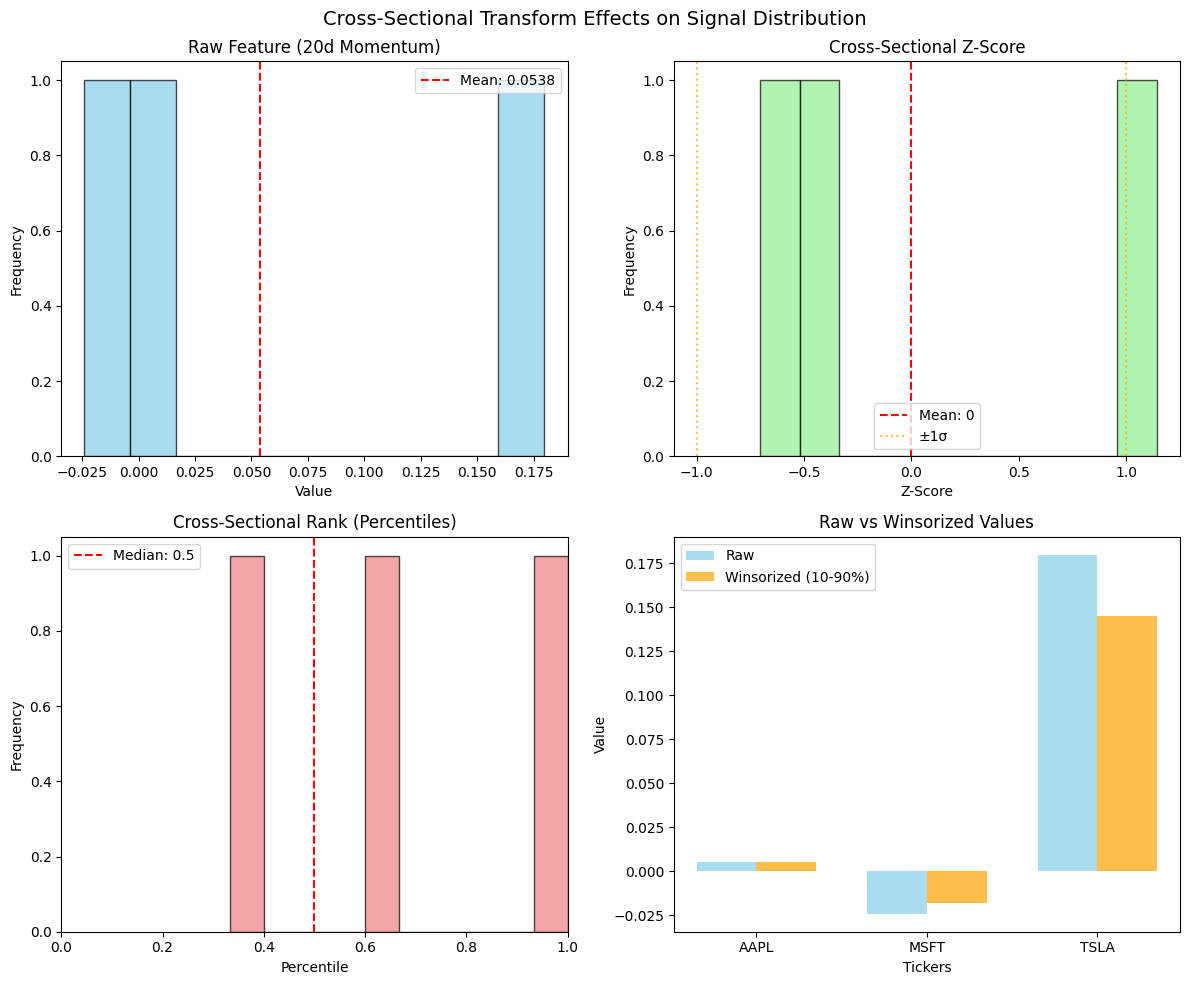

Analysis date: 2025-09-12
Number of assets: 3


In [12]:
# Create visualization of signal distributions
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Cross-Sectional Transform Effects on Signal Distribution', fontsize=14)

# Get the latest date for comparison
latest_date = raw_feature.dropna(how='all').index[-1]
latest_raw = raw_feature.loc[latest_date].dropna()
latest_zscore = cs_z.loc[latest_date].dropna()
latest_rank = cs_r.loc[latest_date].dropna()
latest_winsor = cs_w.loc[latest_date].dropna()

# Raw feature distribution
axes[0,0].hist(latest_raw, bins=10, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Raw Feature (20d Momentum)')
axes[0,0].set_xlabel('Value')
axes[0,0].set_ylabel('Frequency')
axes[0,0].axvline(latest_raw.mean(), color='red', linestyle='--', label=f'Mean: {latest_raw.mean():.4f}')
axes[0,0].legend()

# Z-score distribution
axes[0,1].hist(latest_zscore, bins=10, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0,1].set_title('Cross-Sectional Z-Score')
axes[0,1].set_xlabel('Z-Score')
axes[0,1].set_ylabel('Frequency')
axes[0,1].axvline(0, color='red', linestyle='--', label='Mean: 0')
axes[0,1].axvline(-1, color='orange', linestyle=':', alpha=0.7, label='±1σ')
axes[0,1].axvline(1, color='orange', linestyle=':', alpha=0.7)
axes[0,1].legend()

# Rank distribution
axes[1,0].hist(latest_rank, bins=10, alpha=0.7, color='lightcoral', edgecolor='black')
axes[1,0].set_title('Cross-Sectional Rank (Percentiles)')
axes[1,0].set_xlabel('Percentile')
axes[1,0].set_ylabel('Frequency')
axes[1,0].axvline(0.5, color='red', linestyle='--', label='Median: 0.5')
axes[1,0].set_xlim(0, 1)
axes[1,0].legend()

# Bar chart comparing raw vs winsorized
tickers = latest_raw.index
x_pos = np.arange(len(tickers))
width = 0.35

axes[1,1].bar(x_pos - width/2, latest_raw.values, width, label='Raw', alpha=0.7, color='skyblue')
axes[1,1].bar(x_pos + width/2, latest_winsor.values, width, label='Winsorized (10-90%)', alpha=0.7, color='orange')
axes[1,1].set_title('Raw vs Winsorized Values')
axes[1,1].set_xlabel('Tickers')
axes[1,1].set_ylabel('Value')
axes[1,1].set_xticks(x_pos)
axes[1,1].set_xticklabels(tickers)
axes[1,1].legend()

plt.tight_layout()
plt.show()

print(f"Analysis date: {latest_date.date()}")
print(f"Number of assets: {len(latest_raw)}")


## 5. Signal Construction with make_signal()

The `make_signal()` function is the main workhorse for converting raw features into tradable signals. Let's explore different configurations.


In [13]:
print("=== Signal Construction with make_signal() ===")

# Configuration 1: Basic z-score standardization with lag
signal_basic = S.make_signal(
    feature=mom_20d,
    standardize="zscore",
    winsor=(0.01, 0.99),  # 1%-99% winsorization
    clip=3.0,             # Clip at ±3 standard deviations
    lag=1                 # 1-day lag to avoid look-ahead
)

print("1. Basic Signal (z-score, winsorized, clipped, lagged):")
print(signal_basic.tail().round(4))
print()

# Configuration 2: Rank-based signal
signal_rank = S.make_signal(
    feature=mom_20d,
    standardize="rank",   # Use ranks instead of z-scores
    winsor=None,          # No winsorization
    clip=None,            # No clipping
    lag=1
)

print("2. Rank-based Signal (centered around 0):")
print(signal_rank.tail().round(4))
print(f"   Range: [{signal_rank.iloc[-2].min():.3f}, {signal_rank.iloc[-2].max():.3f}]")
print()

# Configuration 3: No standardization (raw feature with processing)
signal_raw = S.make_signal(
    feature=mom_20d,
    standardize="none",   # Keep raw values
    winsor=(0.05, 0.95),  # 5%-95% winsorization
    clip=None,
    lag=1
)

print("3. Raw Signal (no standardization, winsorized):")
print(signal_raw.tail().round(4))
print()


=== Signal Construction with make_signal() ===
1. Basic Signal (z-score, winsorized, clipped, lagged):
ticker        AAPL    MSFT    TSLA
date                              
2025-09-08  0.5817 -1.1547  0.5730
2025-09-09  0.4420 -1.1448  0.7028
2025-09-10  0.6717 -1.1492  0.4775
2025-09-11  0.0821 -1.0385  0.9564
2025-09-12 -0.3907 -0.7457  1.1364

2. Rank-based Signal (centered around 0):
ticker        AAPL    MSFT    TSLA
date                              
2025-09-08  0.5000 -0.1667  0.1667
2025-09-09  0.1667 -0.1667  0.5000
2025-09-10  0.5000 -0.1667  0.1667
2025-09-11  0.1667 -0.1667  0.5000
2025-09-12  0.1667 -0.1667  0.5000
   Range: [-0.167, 0.500]

3. Raw Signal (no standardization, winsorized):
ticker        AAPL    MSFT    TSLA
date                              
2025-09-08  0.0893 -0.0358  0.0887
2025-09-09  0.0372 -0.0374  0.0494
2025-09-10  0.0307 -0.0380  0.0234
2025-09-11 -0.0125 -0.0503  0.0171
2025-09-12 -0.0141 -0.0352  0.0766



## 6. Neutralization Techniques

Neutralization helps remove unwanted exposures from signals. Let's demonstrate both group and linear neutralization.


In [14]:
print("=== Neutralization Techniques ===")

# Create synthetic group labels (e.g., sectors)
# In practice, these would come from a reference dataset
tickers = close.columns
np.random.seed(42)  # For reproducibility
sectors = ['Tech', 'Finance', 'Consumer', 'Energy', 'Healthcare']
group_labels = pd.Series(
    np.random.choice(sectors, size=len(tickers)), 
    index=tickers
)
print(f"Synthetic sector assignments:")
print(group_labels)
print()

# 1. Group neutralization
signal_base = S.cs_zscore(mom_20d)  # Start with basic z-score
signal_group_neutral = S.neutralize_by_group(signal_base, group_labels)

print("1. Group Neutralization (sector-neutral):")
print("Original signal (last date):")
latest_idx = signal_base.dropna(how='all').index[-1]
orig_values = signal_base.loc[latest_idx].dropna()
neutral_values = signal_group_neutral.loc[latest_idx].dropna()

comparison_df = pd.DataFrame({
    'Original': orig_values,
    'Group_Neutral': neutral_values,
    'Sector': group_labels.reindex(orig_values.index)
})
print(comparison_df.round(4))
print()

# Check that each group has mean ~0 after neutralization
print("Group means after neutralization (should be ~0):")
for sector in sectors:
    sector_mask = group_labels == sector
    sector_tickers = group_labels[sector_mask].index
    if len(sector_tickers) > 0 and sector_tickers[0] in neutral_values.index:
        sector_mean = neutral_values.reindex(sector_tickers).mean()
        print(f"  {sector}: {sector_mean:.6f}")
print()

# 2. Linear neutralization (against volatility)
# Use volatility as an exposure to neutralize against
vol_exposure = vol_20d.copy()
signal_linear_neutral = S.neutralize_linear(signal_base, vol_exposure)

print("2. Linear Neutralization (volatility-neutral):")
print("Signal after linear neutralization (sample):")
print(signal_linear_neutral.tail().round(4))


=== Neutralization Techniques ===
Synthetic sector assignments:
ticker
AAPL        Energy
MSFT    Healthcare
TSLA      Consumer
dtype: object

1. Group Neutralization (sector-neutral):
Original signal (last date):
        Original  Group_Neutral      Sector
ticker                                     
AAPL     -0.4377            0.0      Energy
MSFT     -0.7065            0.0  Healthcare
TSLA      1.1442            0.0    Consumer

Group means after neutralization (should be ~0):
  Consumer: 0.000000
  Energy: 0.000000
  Healthcare: 0.000000

2. Linear Neutralization (volatility-neutral):
Signal after linear neutralization (sample):
ticker        AAPL    MSFT    TSLA
date                              
2025-09-08 -0.4417 -1.8219 -0.9344
2025-09-09 -0.1334 -1.7514 -0.9242
2025-09-10 -1.3627 -1.9083 -1.2295
2025-09-11 -1.4608 -1.3516 -0.7634
2025-09-12 -1.3781 -1.2852 -0.7145
